/opt/anaconda3/lib/python3.8/site-packages/nilearn/datasets/atlas.py:131: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)
/tmp/ipykernel_1774707/1375754557.py:105: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  weight_image = weighted_mask.get_data()
/tmp/ipykernel_1774707/1375754557.py:107: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of vers

CCA mode 1 =  ['Superior frontal gyrus posterior LH' 'Middle frontal gyrus posterior RH'
 'Intermediate primus of Jensen RH' 'Cingulate cortex mid-posterior'
 'Intraparietal sulcus posterior LH']


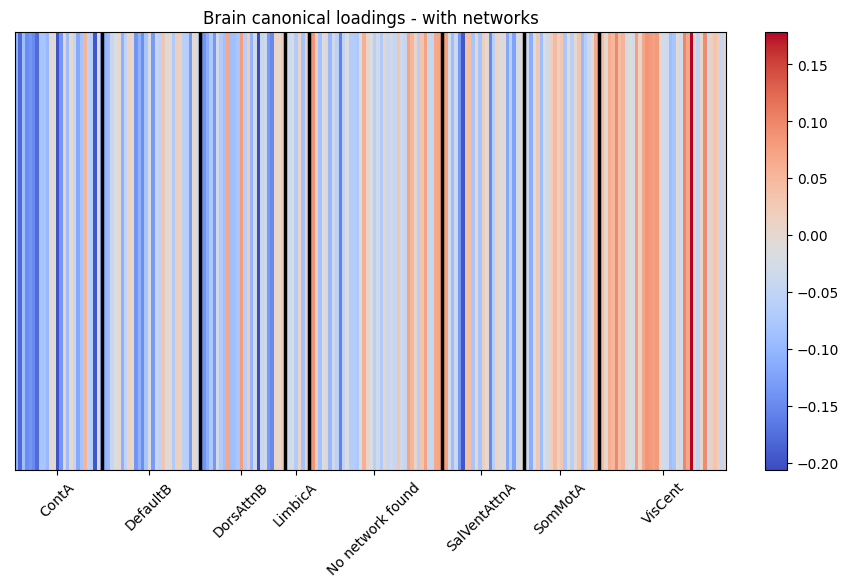

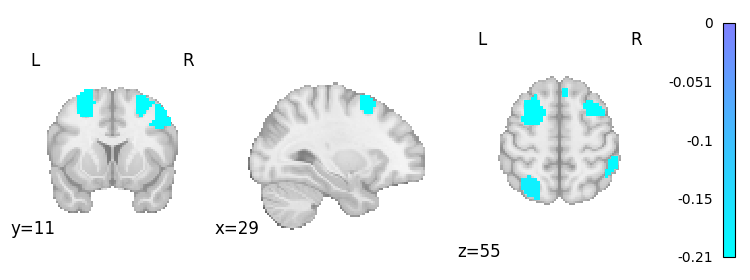

In [1]:
## plot both heatmap and brainplot for all significant variates automatically (& save) - for CCA/PLS-toolkit results
import matplotlib.pyplot as plt
import numpy as np
from nilearn import datasets
from nilearn import plotting
from nilearn.image import index_img
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from nilearn import image as nimg
import os
import nibabel as nib

CCA_path = '/home/leah/Git/Psychiatric_StomachBrain/figures/CCA/control_psychoutliersin/' #'/home/leah/Git/StomachBrain/StomachBrainCCA/scripts/python/CCAdata2plot/CCAPLS_toolkit/loadings/' 

CCA_filename = 'brainloadings.mat' #'stomachbrainloadings_PsychScoresSubscales_CCA1.mat' # 'stomachbrainweights_PsychScoresSubscales_CCA1.mat'
savepath =  '/home/leah/Git/Psychiatric_StomachBrain/figures/CCA/control_psychoutliersin/' #'/home/leah/Git/StomachBrain/StomachBrainCCA/figures/gastricPLV_PsychScoresSubscales/CCAPLS_toolkit/test/' 

if not os.path.exists(savepath):
    # Create the folder
    os.makedirs(savepath)

# load difumo & coordinates
difumo = datasets.fetch_atlas_difumo(dimension=256, resolution_mm=3)
coordinates = plotting.find_probabilistic_atlas_cut_coords(maps_img=difumo.maps)

# White matter, venticle and CSF regions which were removed
difumo_dimensions_rejremoved = 209
idx2rem = [3, 5, 7, 11, 18, 19, 34, 44, 52, 55, 60, 71, 82, 85, 92, 93, 98, 101, 103, 111, 114, 123, 131, 132, 135, 136, 139, 140, 150, 153, 157, 165, 169, 175, 180, 182, 198, 202, 207, 231, 245, 246, 247, 249, 250, 253, 254]
idx2rem = [x - 1 for x in idx2rem] # minus 1 from indices for python (idx2rem values from matlab)
# remove from labels & coordinates too
difumo_labels_rejremoved =np.delete(difumo['labels'], idx2rem)
coordinates = np.delete(coordinates, idx2rem, axis = 0)

# Load CCA results
cca_mat = loadmat(f"{CCA_path}{CCA_filename}") 
brain_loadings_all = cca_mat["weightX"] 

sigvariates = 1 

for sigvariate in range(sigvariates):
    
    brain_loadings = brain_loadings_all[:,sigvariate]

    ################# Plot fmri CCA loadings/weights grouped by network #############################
            
    # reorganise matrix according to network
    reoder_idx = np.argsort(difumo_labels_rejremoved["yeo_networks7"]) 
    brain_loadings_reordered = brain_loadings[reoder_idx]

    # get network labels
    labels = np.unique(difumo_labels_rejremoved["yeo_networks7"]) 
    total_networks = np.unique(difumo_labels_rejremoved["yeo_networks7"], return_counts=True)[1] 

    # sort counts for regions in each network
    counts_end = np.cumsum(total_networks)
    counts_end = np.expand_dims(counts_end, axis = 1)
    counts_start = counts_end[0:-1] +1
    counts_start = np.insert(counts_start, 0, 0)
    counts_start = np.expand_dims(counts_start, axis = 1)
    counts = np.append(counts_start, counts_end, axis=1)

    # plot fmri loadings/weights heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    heatmap = ax.imshow(np.expand_dims(brain_loadings_reordered, axis=0), cmap='coolwarm', aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Brain canonical loadings - with networks')

    # add vertical lines dividing the networks
    for line2plot in counts[1:,0]:
        ax.axvline(line2plot, color='black', linestyle='-', lw=2.5)

    # Set x-axis network labels
    x_ticks = (counts[:, 0] + counts[:, 1]) / 2  # Calculate the midpoint of each division
    x_labels = labels 
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels, rotation=45)

    fig.colorbar(heatmap, fraction=0.032)

    # Adjust subplot parameters to fit the labels
    fig.subplots_adjust(bottom=0.15)

    plt.savefig(f'{savepath}heatmap_CCA{sigvariate+1}loadings_brain_networks.png', bbox_inches='tight')


    ################### brain plot ##############################################

    # Only keep top 5 or 20 nodes (cca/pls toolkit)
    nodes_idx = list(np.argsort(np.abs(brain_loadings), axis=0)[::-1][:5]) 

    # find real index as regions have been removed
    real_nodes_idx = []
    for node in nodes_idx:
        real_nodes_idx.append(np.where(difumo['labels']['difumo_names'] == difumo_labels_rejremoved[node]['difumo_names'])[0][0])

    weight_image = None
    for count, node in enumerate(real_nodes_idx):
        parcel_img = index_img(difumo.maps, node)
        binarymask = nimg.math_img('a > 0', a=parcel_img)
        this_weight = brain_loadings[nodes_idx[count]]
        weighted_mask = nimg.math_img(f'{this_weight}*a', a=binarymask)
        if weight_image is None:
            weight_image = weighted_mask.get_data()
        else:
            weighted_mask_data = weighted_mask.get_data()
            weight_image = np.where(np.abs(weighted_mask_data) > np.abs(weight_image), weighted_mask_data, weight_image)
            #weight_image = np.where(np.abs(weighted_mask_data) < np.abs(weight_image), weighted_mask_data, weight_image)

    # Convert the resulting NumPy array back to a Nifti image
    weight_image = nimg.new_img_like(weighted_mask, weight_image)

    #display = plotting.plot_anat(datasets.load_mni152_template(), draw_cross=False)
    #display.add_overlay(weight_image, colorbar=True, cmap='cool')
    
    plotting.plot_stat_map(weight_image, display_mode='ortho', cmap='cool', black_bg=False, symmetric_cbar=False, draw_cross=False)
            
    plt.savefig(f'{savepath}BrainVoxel_CCA1loadings_multimask.png')
    
    # save as nifti for plotting with MRIcroGL
    nib.save(weight_image, f'{savepath}/cca1_brain_loadings_top5.nii.gz')

    # Save the top brain loading regions to a text file
    np.savetxt(f'{savepath}topbrainloadings{len(np.round(brain_loadings[nodes_idx],3))}_CCA{sigvariate+1}.txt', np.column_stack((difumo['labels'][real_nodes_idx]['difumo_names'], np.round(brain_loadings[nodes_idx],3))), fmt='%s')
    print(f"CCA mode {sigvariate+1} =  {difumo['labels'][real_nodes_idx]['difumo_names']}")
    

In [4]:
brain_loadings[nodes_idx]

array([-0.20575629, -0.1988153 , -0.19607251, -0.19477104, -0.18009525])

/opt/anaconda3/lib/python3.8/site-packages/nilearn/plotting/js_plotting_utils.py:76: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  warnings.warn('you have specified symmetric_cmap=False '



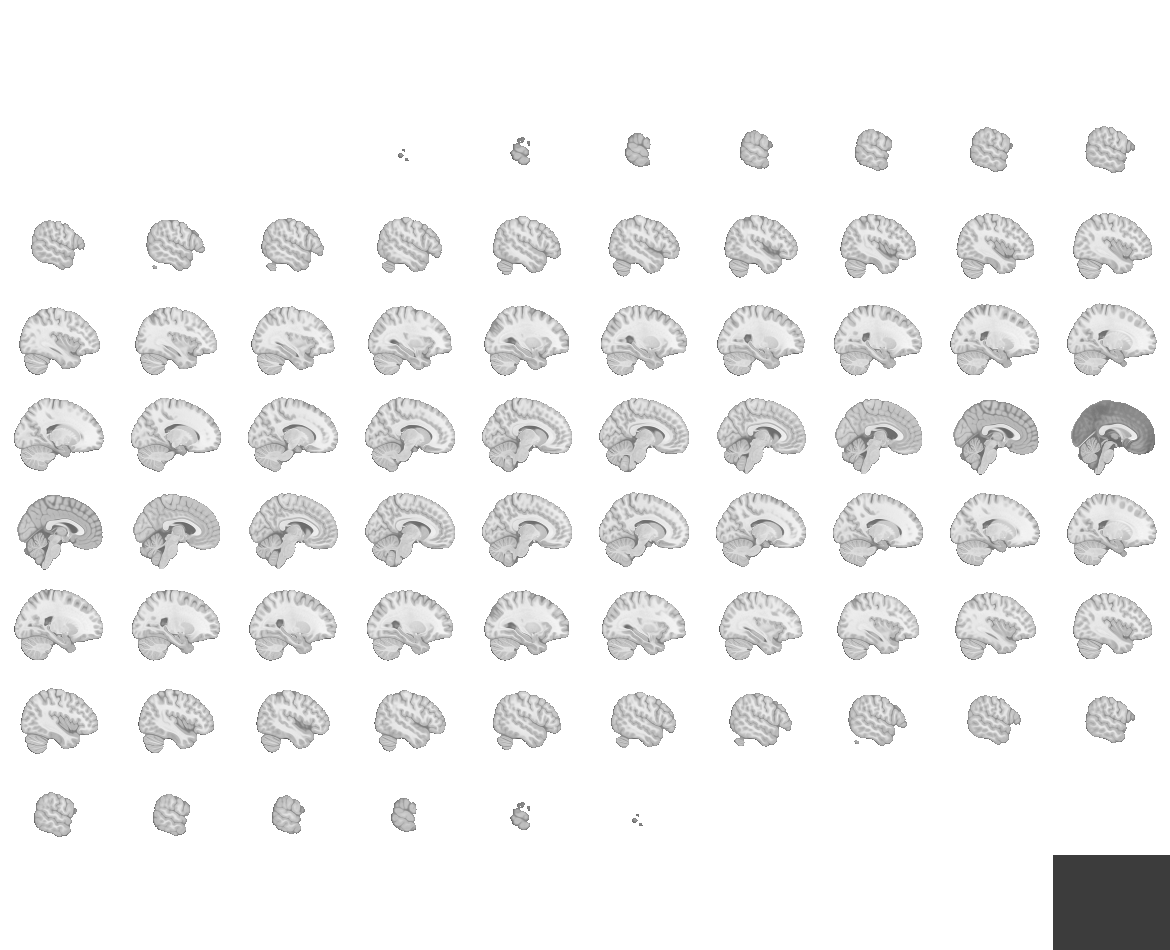
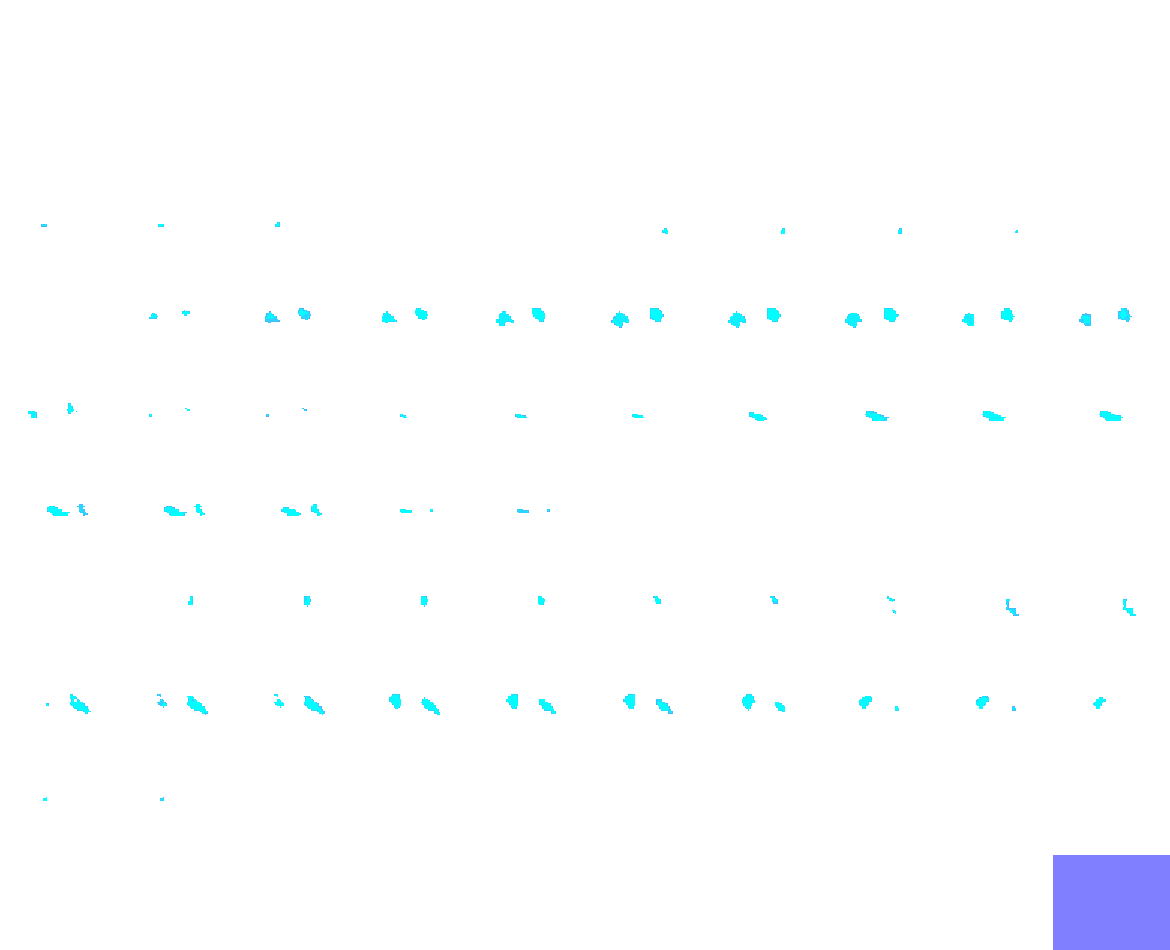

In [2]:
# interactive plot
import matplotlib.pyplot as plt
import nilearn.plotting as plotting

plotting.view_img(weight_image, bg_img='MNI152', threshold=0.05, cmap='cool', black_bg=False, symmetric_cmap=False, draw_cross=False)


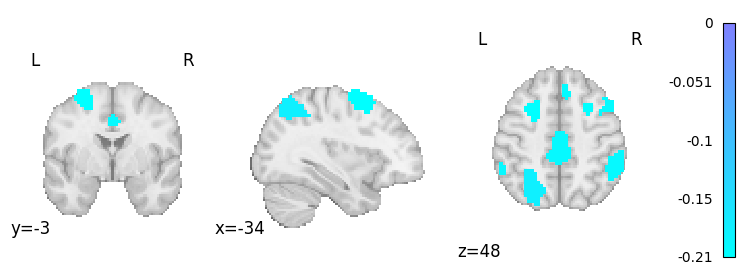

In [3]:
# Specify the coordinates for the desired slice
x = -34 #28  # X-coordinate
y = -3 #-8  # Y-coordinate
z = 48 #20  # Z-coordinate

# Generate the plot
plotting.plot_stat_map(weight_image, cut_coords=(x, y, z), display_mode='ortho', cmap='cool', black_bg=False, symmetric_cbar=False, draw_cross=False)#, threshold=0.05

# Save the plot as a PNG image
plt.savefig(f'{savepath}BrainVoxel_CCA{sigvariate+1}loadings_brain_multimask.png')